## Explore performance of TF-IDF vs Bag-of-words using Stemmed and Lemmatized corpus

In [1]:
from datetime import datetime, timezone
import json
import logging
import os
import re
import time

import numpy as np
import pandas as pd
import pickle

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, LdaModel, LdaMulticore, Phrases, TfidfModel
from gensim.models.phrases import Phraser
from gensim.models.wrappers import ldamallet

# nltk
import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from nltk.stem.snowball import SnowballStemmer

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

import warnings

pyLDAvis.enable_notebook()
# Enbale logging for gensim
logging.basicConfig(format='%(asctime)s: %(levelname)s : %(message)s', level=logging.ERROR)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
HOME = os.environ['HOME']
KEYS = f'{HOME}/config/db.json'
ENV = 'dev'
NOW = datetime.now(timezone.utc)
TODAY = NOW.date()

DATA_DIR = '../data'
MODEL_DIR = '../model'
SQL_DIR = '../sql'
OUT_DIR = '../output'

DEV = True

In [3]:
if DEV:
    RUN_DATE = '2021-03-15'
else:
    RUN_DATE = str(TODAY)
RUN_DATE

'2021-03-15'

#### Load data

In [4]:
# clean comments
data = pd.read_csv(f'{DATA_DIR}/clean_data_{RUN_DATE}.csv')

In [5]:
data.head()

,comment,title,subreddit,score
0,company original instance container docker swa...,building jenkins pipeline,devops,2
1,analogy breaks actively maintained jenkins hor...,building jenkins pipeline,devops,2
2,solutions architecture customer engineering pe...,industries life devops,devops,3
3,moved jenkins helm jenkins operator working au...,building jenkins pipeline,devops,1
4,unsure open moving based profit hospital perso...,industries life devops,devops,3


In [6]:
uniqe_titles = data.title.unique()
print(data.title.unique())

['building jenkins pipeline' 'industries life devops' 'experience relic'
 ... 'successfull reflection attack authentication'
 'software examples configure powerful permission surveillance'
 'learning path deep fake machine learning apps reface wombo ai deep nostalgia']


In [7]:
data['comment_len'] = data.comment.apply(len)

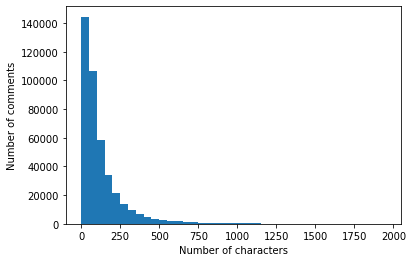

In [8]:
plt.hist(data.comment_len.values, bins = range(0, 2000, 50))
plt.xlabel('Number of characters')
plt.ylabel('Number of comments')
plt.show()

## Preprocess comments

1. Combine all comments under the same post - prepend post title
2. Tokenize comments
3. Remove stopwords
5. Make ngrams, stem and lemmatize the tokens (words in comments)
6. Create Bag-of-words and TF-IDF vector representation of the tokens

#### Combining comments under the same title (post)

In [9]:
df_grouped = data.groupby(['title']) #['comment'].transform(lambda x: ' '.join(x))

In [10]:
titles = list(df_grouped.groups.keys())
all_comments = []
for title in titles:
    # combine all comments - prepend title
    title_comments = title + ' ' + ' '.join(
        df_grouped.get_group(title).comment)
    all_comments.append(title_comments)

In [11]:
len(all_comments)

27016

In [12]:
data = pd.DataFrame({
    'title':titles,
    'text': all_comments})

In [13]:
data.head()

,title,text
0,00 google hold notifications card google subs,00 google hold notifications card google subs ...
1,0365 email accounts,0365 email accounts block powershell access ad...
2,0365 roll critical account protection accounts...,0365 roll critical account protection accounts...
3,06 secret history windows zipfolders original ...,06 secret history windows zipfolders original ...
4,10 000 double pendulums double pendulum simula...,10 000 double pendulums double pendulum simula...


In [14]:
data.text[0]

'00 google hold notifications card google subs called citibank safe wait alerts suspicious plenty dispute cancel card 4 charges today odd credit card remember straight update card details domain registrars assume compromised testing card dumbshitontheright report card lost stolen'

### Tokenization


Tokenization is the process of breaking complex data (like paragraphs) into simple units called __tokens__

In [15]:
def tokenize(doc):
    for sentence in doc:
        yield(simple_preprocess(str(sentence), deacc=True)) # deacc=True removes punctuations

### Remove stopwords

In [16]:
stop_words = stopwords.words('english')
stop_words.extend(['feel', 'aint', 'wtf', 'hell', 'kid', 'heh', 'ha', 'youtu', 
                   'hmm', 'не', 'kinda', 'fine', 'nah', 'nope', 'huh', 'die',
                   'joke', 'yup', 'great', 'fun', 'issue', 'stuff', 'point', 
                   'feel', 'crap', 'fucking', 'fuck', 'dude', 'damn', 'suck',
                   'lmao', 'stupid', 'haha', 'lol', 'nice', 'yeah', 'cool',  
                   'didnt', 'youll', 'youv', 'big', 'yep', 'bot', 'yikes',
                   'ya', 'tho', 'jesus', 'totally', 'chill', 'god', 'amazing',
                   'nep', 'remindme', 'holy', 'as', 'wanna', 'ftw', 'enjoy',
                   'gotta', 'crazy', 'die', 'small', 'hey', 'ban', 'bro',
                   'guess', 'kid', 'bad', 'long', 'interesting', 'man',
                   'wrong', 'kid', 'easy', 'difficult', 'upvote', 'like',
                   'funny', 'friend', 'literally', 'hate', 'free', 'sucks',
                   'dont', 'ill', 'https', 'laugh', 'ass', 'omg'])

In [17]:
len(stop_words)

268

In [18]:
def remove_stopwords(doc):
    return doc.apply(
        lambda sent: [word for word in sent if word not in stop_words])

### Stemming
- Stemming is a normalization technique where list of tokenized words are converted into shorter root words called stems (note: stems are not always the root word)
- Drop last letter or prefix or suffix - may not produce meaningful words
- Stemming may reduce the accuracy of the model

In [19]:
def stemming(doc, stemmer_type):
    if stemmer_type=='port':
        stemmer = PorterStemmer()
    elif stemmer_type=='snow':
        stemmer = SnowballStemmer('english')
    stemmed_text = doc.apply(
            lambda sent: [stemmer.stem(word) for word in sent])
    return stemmed_text

### Lemmatization
- Lemmatization is the morphological analysis of the words - returning meaningful words
- Requires more disk space and processing time
- Leads to higher model accuaracy
- Root word is called __lemma__

In [20]:
lemmatizer = WordNetLemmatizer()
def lemmatization(doc):
    return doc.apply(
        lambda sent: [lemmatizer.lemmatize(word) for word in sent])

In [21]:
tokenized_text = list(tokenize(data.text))
data['tokens'] = tokenized_text
print('Tokenized:\n', data.tokens[0])

# Remove stopwords
nostops_text = remove_stopwords(data.tokens)
print('\nWithout stopwords:\n', nostops_text[0])
data['tokens'] = nostops_text # replace with clean tokenized

# Form bigrams and trigrams
bigram = Phrases(data.tokens, min_count=3, threshold=10) # higher threshold fewer places
bigram_mod = Phraser(bigram)
print('\nBigrams:\n', bigram[data.tokens[0]])
data['bigram'] = [bigram_mod[doc] for doc in data.tokens]

trigram = Phrases(bigram[data.tokens], threshold=10) # higher threshold fewer places
trigram_mod = Phraser(trigram)
print('\nTrigrams:\n', trigram[data.tokens[0]])
data['trigram'] = [trigram_mod[bigram_mod[doc]] for doc in data.tokens]

# Snowball stemmer
stemmed_text = stemming(data.tokens, 'snow')
data['stem_text'] = stemmed_text 
data['stem_bi'] = stemming(data.bigram, 'snow')
data['stem_tri'] = stemming(data.trigram, 'snow')
print('\nStemmed:\n', stemmed_text[0])


# Lemmatization
lemmatized_text = lemmatization(data.tokens)
print('\nLemmatized:\n', lemmatized_text[0])
data['lemma_text'] = lemmatized_text
data['lemma_bi'] = lemmatization(data.bigram)
data['lemma_tri'] = lemmatization(data.trigram)

Tokenized:
 ['google', 'hold', 'notifications', 'card', 'google', 'subs', 'called', 'citibank', 'safe', 'wait', 'alerts', 'suspicious', 'plenty', 'dispute', 'cancel', 'card', 'charges', 'today', 'odd', 'credit', 'card', 'remember', 'straight', 'update', 'card', 'details', 'domain', 'registrars', 'assume', 'compromised', 'testing', 'card', 'report', 'card', 'lost', 'stolen']

Without stopwords:
 ['google', 'hold', 'notifications', 'card', 'google', 'subs', 'called', 'citibank', 'safe', 'wait', 'alerts', 'suspicious', 'plenty', 'dispute', 'cancel', 'card', 'charges', 'today', 'odd', 'credit', 'card', 'remember', 'straight', 'update', 'card', 'details', 'domain', 'registrars', 'assume', 'compromised', 'testing', 'card', 'report', 'card', 'lost', 'stolen']

Bigrams:
 ['google', 'hold', 'notifications', 'card', 'google', 'subs', 'called', 'citibank', 'safe', 'wait', 'alerts', 'suspicious', 'plenty', 'dispute', 'cancel', 'card', 'charges', 'today', 'odd', 'credit_card', 'remember', 'straight

### Create dictionary, corpus and vectorized corpus needed for topic modeling

In [22]:
data.head()

,title,text,tokens,bigram,trigram,stem_text,stem_bi,stem_tri,lemma_text,lemma_bi,lemma_tri
0,00 google hold notifications card google subs,00 google hold notifications card google subs ...,"[google, hold, notifications, card, google, su...","[google, hold, notifications, card, google, su...","[google, hold, notifications, card, google, su...","[googl, hold, notif, card, googl, sub, call, c...","[googl, hold, notif, card, googl, sub, call, c...","[googl, hold, notif, card, googl, sub, call, c...","[google, hold, notification, card, google, sub...","[google, hold, notification, card, google, sub...","[google, hold, notification, card, google, sub..."
1,0365 email accounts,0365 email accounts block powershell access ad...,"[email, accounts, block, powershell, access, a...","[email_accounts, block, powershell, access, ad...","[email_accounts, block, powershell, access, ad...","[email, account, block, powershel, access, adm...","[email_account, block, powershel, access, admi...","[email_account, block, powershel, access, admi...","[email, account, block, powershell, access, ad...","[email_accounts, block, powershell, access, ad...","[email_accounts, block, powershell, access, ad..."
2,0365 roll critical account protection accounts...,0365 roll critical account protection accounts...,"[roll, critical, account, protection, accounts...","[roll, critical, account, protection, accounts...","[roll, critical, account, protection, accounts...","[roll, critic, account, protect, account, high...","[roll, critic, account, protect, account, high...","[roll, critic, account, protect, account, high...","[roll, critical, account, protection, account,...","[roll, critical, account, protection, account,...","[roll, critical, account, protection, account,..."
3,06 secret history windows zipfolders original ...,06 secret history windows zipfolders original ...,"[secret, history, windows, zipfolders, origina...","[secret_history, windows, zipfolders, original...","[secret_history_windows, zipfolders, original_...","[secret, histori, window, zipfold, origin, aut...","[secret_histori, window, zipfold, original_aut...","[secret_history_window, zipfold, original_auth...","[secret, history, window, zipfolders, original...","[secret_history, window, zipfolders, original_...","[secret_history_windows, zipfolders, original_..."
4,10 000 double pendulums double pendulum simula...,10 000 double pendulums double pendulum simula...,"[double, pendulums, double, pendulum, simulati...","[double_pendulums, double_pendulum, simulation...","[double_pendulums, double_pendulum, simulation...","[doubl, pendulum, doubl, pendulum, simul, shar...","[double_pendulum, double_pendulum, simul, shar...","[double_pendulum, double_pendulum, simul, shar...","[double, pendulum, double, pendulum, simulatio...","[double_pendulums, double_pendulum, simulation...","[double_pendulums, double_pendulum, simulation..."


In [23]:
# Create dictionary representation of the documents
def build_corpus(doc, filter_extremes=True):
    doc_dict = corpora.Dictionary(doc)
    if filter_extremes:
        # Filter out words that occur in less than 20% documents, and above 50% documents
        doc_dict.filter_extremes(no_below=20, no_above=0.5)
    # Bag of words
    corpus = [doc_dict.doc2bow(text) for text in doc]
    # Compute TF-IDF score for each word in BoW (stemmed corpus)
    tfidf_mod = TfidfModel(corpus, normalize=True)
    vec_corpus = tfidf_mod[corpus]
    return doc_dict, corpus, vec_corpus, tfidf_mod

In [24]:
# Build stem corpus
dict_stem, corpus_stem, vec_corpus_stem, tfid_stem_mod = build_corpus(data.stem_text)
dict_stem_bi, corpus_stem_bi, vec_corpus_stem_bi, tfid_stem_bi_mod = build_corpus(data.stem_bi)
dict_stem_tri, corpus_stem_tri, vec_corpus_stem_tri, tfid_stem_tri_mod = build_corpus(data.stem_tri)


In [25]:
# Build lemma corpus
dict_lemma, corpus_lemma, vec_corpus_lemma, tfid_lemma_mod = build_corpus(data.lemma_text)
dict_lemma_bi, corpus_lemma_bi, vec_corpus_lemma_bi, tfid_lemma_bi_mod = build_corpus(data.lemma_bi)
dict_lemma_tri, corpus_lemma_tri, vec_corpus_lemma_tri, tfid_lemma_tri_mod = build_corpus(data.lemma_tri)


### Building the topic model

In [78]:
# Set training parameters.
num_topics = 7, # no. of subreddits
chunksize = 500
passes = 10
iterations = 500
eval_every = None # None - don't evaluate model perplexity, takes too much time.
workers = 6

# alpha and eta - affect sparsity of topics - defaults to 1.0/num_topics
# chunksize - control how many documents are processed at a time in training
# update_every - determined how often the parameters should be updated
# passes - total number of training passes
# iteration - control how often a particular loop is repeated over each document 
# eval_every - evaluate no. of passes and iterations
# workers - number of workers processes to be used for parallelization. 
#         - If None all available cores (as estimated by workers=cpu_count()-1 will be used

# Note - set passes and iterations high

In [79]:
# Print the keywords in the topics
def print_topics(model):
    for topic_num, words_in_topic in model.print_topics(-1):
        print(f'Topic {topic_num+1}:  Words: {words_in_topic}')

In [80]:
def print_coherence_score(model, corpus, dictionary, texts):
    # Compute Perplexity - lemmatized
    print(f'\n- Perplexity: {model.log_perplexity(corpus):.4f}')  # a measure of how good the model is. lower the better.
    # Compute Coherence Score using lemmatized comments
    coherence = CoherenceModel(
        model=model, texts=texts, dictionary=dictionary, coherence='c_v').get_coherence()
    print(f'- Coherence Score: {coherence:.4f}')

#### LDA on TF-IDF

In [81]:
# corpus - bow/tfidf dictionary of lemmatized or stemmed words

def build_lda(
    corpus, dictionary, corpus_type, num_topics, texts, chunksize=500, 
    passes=10, iterations=500, eval_every=None, workers=6):
    start = time.time()
    print(f'Building LDA model using {corpus_type} corpus...')
    mod = LdaMulticore(corpus=corpus,
                       id2word=dictionary,
                       num_topics=num_topics,
                       chunksize=chunksize,
                       passes=passes,
                       iterations=iterations,
                       workers=workers,
                       eval_every=eval_every)
    print(f' - {time.time()-start:.4f}s\n')
    print_topics(mod)
    print_coherence_score(mod, corpus, dictionary, texts)
    return mod

In [82]:
# 7 topic tfidf-stem corpus
lda_tfidf_stem_mod = build_lda(
    corpus=vec_corpus_stem,
    dictionary=dict_stem,
    corpus_type='tfidf-stem',
    texts=data.stem_text,
    num_topics=7)

Building LDA model using tfidf-stem corpus...
 - 219.2608s

Topic 1:  Words: 0.009*"server" + 0.007*"network" + 0.006*"window" + 0.006*"connect" + 0.006*"router" + 0.006*"switch" + 0.006*"vpn" + 0.005*"port" + 0.005*"dns" + 0.005*"vlan"
Topic 2:  Words: 0.026*"wsus" + 0.008*"sidebar" + 0.008*"sysprep" + 0.007*"vcenter" + 0.005*"stig" + 0.004*"netbio" + 0.004*"websocket" + 0.004*"wmi" + 0.003*"sentinel" + 0.003*"nordvpn"
Topic 3:  Words: 0.004*"card" + 0.004*"intel" + 0.004*"game" + 0.004*"price" + 0.004*"amd" + 0.004*"power" + 0.003*"laptop" + 0.003*"gpu" + 0.003*"nvidia" + 0.003*"drive"
Topic 4:  Words: 0.013*"password" + 0.010*"email" + 0.007*"account" + 0.007*"secur" + 0.006*"attack" + 0.005*"user" + 0.005*"exchang" + 0.004*"phone" + 0.004*"hack" + 0.004*"microsoft"
Topic 5:  Words: 0.012*"intun" + 0.010*"pdq" + 0.010*"sccm" + 0.010*"solarwind" + 0.008*"defend" + 0.008*"mdt" + 0.007*"bitlock" + 0.007*"orion" + 0.006*"fireey" + 0.006*"tpm"
Topic 6:  Words: 0.012*"job" + 0.009*"secur"

In [83]:
viz = pyLDAvis.gensim.prepare(lda_tfidf_stem_mod, vec_corpus_stem, dict_stem)
viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.034862  0.017033       1        1  36.809208
2      0.007332  0.004784       2        1  19.403522
0      0.116368 -0.150895       3        1  16.977989
3      0.112010 -0.061332       4        1  12.282870
5      0.112886  0.195217       5        1   9.964018
4     -0.203275 -0.038834       6        1   2.526235
1     -0.180183  0.034026       7        1   2.036163, topic_info=          Term        Freq       Total Category  logprob  loglift
55    password  288.000000  288.000000  Default  30.0000  30.0000
95         job  291.000000  291.000000  Default  29.0000  29.0000
1371     secur  409.000000  409.000000  Default  28.0000  28.0000
4099      wsus   95.000000   95.000000  Default  27.0000  27.0000
42       email  247.000000  247.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
5975       cis    8.205314   16.417213   Topic7  -6.0227   3.2006
8278  datastor    5.516637   11.630154   Topic7  -6.4197   3.1483
6196      hehe    3.704326    7.974407   Topic7  -6.8180   3.1274
7852       wat    3.408755    6.688234   Topic7  -6.9011   3.2201
2315    golang    3.680164   15.129162   Topic7  -6.8245   2.4804

[447 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1846      1  0.950705  abstract
29        1  0.184650    access
29        2  0.060119    access
29        3  0.412242    access
29        4  0.326358    access
...     ...       ...       ...
9589      4  0.150839      yada
9589      7  0.754196      yada
5375      4  0.921197   yubikey
3046      2  0.970124       zen
3046      3  0.024875       zen

[1145 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 3, 1, 4, 6, 5, 2])

In [84]:
# 2 topic tfidf-stem corpus
lda_tfidf_stem_2_top_mod = build_lda(
    corpus=vec_corpus_stem,
    dictionary=dict_stem,
    corpus_type='tfidf-stem',
    texts=data.stem_text,
    num_topics=2)

Building LDA model using tfidf-stem corpus...
 - 213.8470s

Topic 1:  Words: 0.006*"server" + 0.005*"window" + 0.005*"user" + 0.004*"file" + 0.004*"password" + 0.004*"network" + 0.003*"connect" + 0.003*"devic" + 0.003*"email" + 0.003*"instal"
Topic 2:  Words: 0.003*"learn" + 0.003*"code" + 0.003*"job" + 0.003*"compani" + 0.002*"program" + 0.002*"model" + 0.002*"secur" + 0.002*"project" + 0.002*"languag" + 0.002*"game"

- Perplexity: -8.5179
- Coherence Score: 0.4210


In [85]:
viz = pyLDAvis.gensim.prepare(lda_tfidf_stem_2_top_mod, vec_corpus_stem, dict_stem)
viz

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.121384  0.0       1        1  55.678360
0     -0.121384  0.0       2        1  44.321632, topic_info=          Term        Freq       Total Category  logprob  loglift
806     server  422.000000  422.000000  Default  30.0000  30.0000
115     window  347.000000  347.000000  Default  29.0000  29.0000
64        user  353.000000  353.000000  Default  28.0000  28.0000
55    password  283.000000  283.000000  Default  27.0000  27.0000
882       file  291.000000  291.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
819        app  191.363083  230.020233   Topic2  -5.9537   0.6297
97       manag  203.964767  308.495911   Topic2  -5.8899   0.3999
586    support  170.631363  243.514694   Topic2  -6.0684   0.4580
778       site  162.555267  191.647522   Topic2  -6.1169   0.6491
1371     secur  179.697296  399.877808   Topic2  -6.0166   0.0138

[152 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
29        1  0.076632   access
29        2  0.923845   access
30        1  0.073370  account
30        2  0.927915  account
1061      1  0.033748  address
...     ...       ...      ...
1438      2  0.997591      vpn
2559      1  0.010124     wifi
2559      2  0.992155     wifi
115       1  0.017288   window
115       2  0.982549   window

[233 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

In [86]:
# 7 topics bow-stem corpus
lda_bow_stem_mod = build_lda(
    corpus=corpus_stem,
    dictionary=dict_stem,
    corpus_type='bow-stem',
    texts=data.stem_text,
    num_topics=7)

Building LDA model using bow-stem corpus...
 - 73.4355s

Topic 1:  Words: 0.021*"network" + 0.015*"switch" + 0.011*"connect" + 0.011*"port" + 0.010*"devic" + 0.008*"router" + 0.008*"rout" + 0.008*"firewal" + 0.007*"vlan" + 0.007*"traffic"
Topic 2:  Words: 0.012*"secur" + 0.010*"password" + 0.009*"googl" + 0.008*"email" + 0.007*"compani" + 0.007*"user" + 0.006*"attack" + 0.006*"data" + 0.006*"account" + 0.005*"access"
Topic 3:  Words: 0.015*"model" + 0.014*"data" + 0.013*"learn" + 0.012*"paper" + 0.009*"train" + 0.007*"ai" + 0.007*"problem" + 0.007*"imag" + 0.005*"understand" + 0.005*"algorithm"
Topic 4:  Words: 0.019*"server" + 0.015*"window" + 0.014*"user" + 0.010*"file" + 0.008*"set" + 0.008*"manag" + 0.008*"updat" + 0.008*"instal" + 0.007*"microsoft" + 0.007*"cloud"
Topic 5:  Words: 0.014*"compani" + 0.013*"job" + 0.009*"manag" + 0.009*"work" + 0.007*"start" + 0.007*"team" + 0.007*"learn" + 0.006*"secur" + 0.006*"day" + 0.006*"experi"
Topic 6:  Words: 0.012*"game" + 0.010*"perform" 

In [87]:
viz = pyLDAvis.gensim.prepare(lda_bow_stem_mod, corpus_stem, dict_stem)
viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.047922 -0.023491       1        1  21.816366
5      0.072390  0.181017       2        1  19.252224
6      0.049202 -0.053668       3        1  14.726235
3     -0.159688 -0.067083       4        1  13.323397
1     -0.015272 -0.047545       5        1  12.719856
0     -0.146954  0.074886       6        1   9.768842
2      0.152401 -0.064115       7        1   8.393077, topic_info=         Term          Freq         Total Category  logprob  loglift
200      code  26505.000000  26505.000000  Default  30.0000  30.0000
806    server  25318.000000  25318.000000  Default  29.0000  29.0000
1558  network  24189.000000  24189.000000  Default  28.0000  28.0000
394   languag  13494.000000  13494.000000  Default  27.0000  27.0000
115    window  16873.000000  16873.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
11      googl   1837.858276  13307.460938   Topic7  -5.7346   0.4980
154      base   1831.356812  13615.464844   Topic7  -5.7381   0.4716
485      post   1814.491089  12430.931641   Topic7  -5.7474   0.5534
181      case   1804.528809  18386.849609   Topic7  -5.7529   0.1564
334   general   1694.451782  10024.409180   Topic7  -5.8158   0.7001

[625 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
4648      4  0.997691      aad
29        1  0.031751   access
29        2  0.033515   access
29        3  0.063219   access
29        4  0.330843   access
...     ...       ...      ...
5375      5  0.976396  yubikey
3046      2  0.994677      zen
3046      3  0.004412      zen
3046      6  0.000679      zen
5420      3  0.996338      zig

[2132 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 6, 7, 4, 2, 1, 3])

In [88]:
# 2 topic bow-stem corpus
lda_bow_stem_2top_mod = build_lda(
    corpus=corpus_stem,
    dictionary=dict_stem,
    corpus_type='bow-stem',
    texts=data.stem_text,
    num_topics=2)

Building LDA model using bow-stem corpus...
 - 41.7478s

Topic 1:  Words: 0.006*"work" + 0.005*"compani" + 0.005*"code" + 0.005*"manag" + 0.005*"network" + 0.005*"secur" + 0.005*"server" + 0.005*"data" + 0.004*"user" + 0.004*"learn"
Topic 2:  Words: 0.009*"game" + 0.008*"perform" + 0.007*"card" + 0.007*"price" + 0.007*"power" + 0.006*"core" + 0.006*"amd" + 0.006*"intel" + 0.006*"buy" + 0.005*"product"

- Perplexity: -7.7344
- Coherence Score: 0.5218


In [89]:
viz = pyLDAvis.gensim.prepare(lda_bow_stem_2top_mod, corpus_stem, dict_stem)
viz

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.103356  0.0       1        1  72.305527
1     -0.103356  0.0       2        1  27.694469, topic_info=         Term          Freq         Total Category  logprob  loglift
333      game  19010.000000  19010.000000  Default  30.0000  30.0000
475   perform  19086.000000  19086.000000  Default  29.0000  29.0000
4        card  13094.000000  13094.000000  Default  28.0000  28.0000
771     price  13056.000000  13056.000000  Default  27.0000  27.0000
1321    power  15068.000000  15068.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
586   support   6160.129395  20179.373047   Topic2  -5.7190   0.0974
1284    money   5023.201172  10697.785156   Topic2  -5.9230   0.5280
181      case   5680.791504  18456.548828   Topic2  -5.8000   0.1056
1014   switch   5355.817871  14572.570312   Topic2  -5.8589   0.2830
160       bit   5267.416504  13657.308594   Topic2  -5.8756   0.3312

[193 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
29        1  0.923997  access
29        2  0.075938  access
32        1  0.999420   admin
32        2  0.000525   admin
725       1  0.000092     amd
...     ...       ...     ...
793       2  0.999492      xt
7189      1  0.998924    yaml
7189      2  0.001158    yaml
3046      1  0.000341     zen
3046      2  0.999763     zen

[324 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

In [90]:
# 7 topics tfidf-stem-bi corpus
lda_tfidf_stem_bi_mod = build_lda(
    corpus=vec_corpus_stem_bi,
    dictionary=dict_stem_bi,
    corpus_type='tfidf-stem-bi',
    texts=data.stem_bi,
    num_topics=7)

Building LDA model using tfidf-stem-bi corpus...
 - 215.0113s

Topic 1:  Words: 0.006*"code" + 0.005*"model" + 0.004*"languag" + 0.004*"paper" + 0.004*"python" + 0.003*"data" + 0.003*"project" + 0.003*"github" + 0.003*"imag" + 0.003*"learn"
Topic 2:  Words: 0.003*"job" + 0.003*"compani" + 0.002*"learn" + 0.002*"game" + 0.002*"start" + 0.002*"experi" + 0.002*"secur" + 0.002*"price" + 0.002*"buy" + 0.002*"intel"
Topic 3:  Words: 0.007*"tensorflow" + 0.005*"vaniti" + 0.005*"web_arxiv" + 0.004*"imagenet" + 0.004*"kali" + 0.004*"pdf_link" + 0.004*"landing_read" + 0.004*"kaggl" + 0.004*"feature_upd" + 0.003*"love_feedback"
Topic 4:  Words: 0.007*"shared_mailbox" + 0.006*"zabbix" + 0.005*"prtg" + 0.005*"stp" + 0.005*"stylegan" + 0.004*"duo" + 0.004*"telegram" + 0.004*"totp" + 0.003*"remoteapp" + 0.003*"snapchat"
Topic 5:  Words: 0.006*"email" + 0.006*"password" + 0.005*"secur" + 0.004*"attack" + 0.004*"hack" + 0.004*"account" + 0.004*"phone" + 0.003*"googl" + 0.003*"websit" + 0.003*"compani"


In [91]:
viz = pyLDAvis.gensim.prepare(lda_tfidf_stem_bi_mod, vec_corpus_stem_bi, dict_stem_bi)
viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.050873  0.024223       1        1  37.366192
6      0.173739 -0.082981       2        1  25.380724
0      0.122641  0.162520       3        1  18.780457
4      0.109503 -0.086110       4        1  12.181925
2     -0.153243 -0.002706       5        1   2.101233
3     -0.151590 -0.008688       6        1   2.096703
5     -0.151923 -0.006257       7        1   2.092756, topic_info=             Term        Freq       Total Category  logprob  loglift
49       password  175.000000  175.000000  Default  30.0000  30.0000
1169        email  185.000000  185.000000  Default  29.0000  29.0000
180          code  272.000000  272.000000  Default  28.0000  28.0000
769        server  342.000000  342.000000  Default  27.0000  27.0000
366       languag  148.000000  148.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
4253       bandit    7.266624    8.713028   Topic7  -6.1848   3.6852
12035    gpu_land   16.798576   22.148993   Topic7  -5.3468   3.5902
12123     godaddi    9.593332   13.997783   Topic7  -5.9071   3.4889
13563         vae    8.256681   11.833469   Topic7  -6.0571   3.5068
7387   blockchain    6.778495   22.244381   Topic7  -6.2544   2.6784

[447 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
1882       1  0.083300  abstract
1882       3  0.860768  abstract
26         1  0.110706    access
26         2  0.611289    access
26         3  0.077013    access
...      ...       ...       ...
6331       6  0.454666   yubikey
8300       6  0.969173    zabbix
10098      5  0.831558     zdnet
3266       1  0.938938       zen
3266       2  0.031298       zen

[916 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 7, 1, 5, 3, 4, 6])

In [92]:
# 2 topics tfidf-stem-bi corpus
lda_tfidf_stem_bi_2top_mod = build_lda(
    corpus=vec_corpus_stem_bi,
    dictionary=dict_stem_bi,
    corpus_type='tfidf-stem-bi',
    texts=data.stem_bi,
    num_topics=2)

Building LDA model using tfidf-stem-bi corpus...
 - 204.5545s

Topic 1:  Words: 0.004*"server" + 0.003*"user" + 0.003*"window" + 0.003*"devic" + 0.003*"network" + 0.003*"set" + 0.002*"instal" + 0.002*"switch" + 0.002*"file" + 0.002*"connect"
Topic 2:  Words: 0.003*"learn" + 0.003*"code" + 0.003*"job" + 0.003*"compani" + 0.003*"secur" + 0.002*"program" + 0.002*"project" + 0.002*"data" + 0.002*"model" + 0.002*"start"

- Perplexity: -8.8909
- Coherence Score: 0.4388


In [93]:
viz = pyLDAvis.gensim.prepare(lda_tfidf_stem_bi_2top_mod, vec_corpus_stem_bi, dict_stem_bi)
viz

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.103204  0.0       1        1  51.132263
1     -0.103204  0.0       2        1  48.867737, topic_info=          Term        Freq       Total Category  logprob  loglift
769     server  350.000000  350.000000  Default  30.0000  30.0000
369      learn  281.000000  281.000000  Default  29.0000  29.0000
100     window  278.000000  278.000000  Default  28.0000  28.0000
230      devic  245.000000  245.000000  Default  27.0000  27.0000
85         job  266.000000  266.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
619      write  124.415306  162.045853   Topic2  -6.4951   0.4518
1327  question  135.413376  219.288864   Topic2  -6.4104   0.2340
755       work  143.573654  285.415497   Topic2  -6.3519   0.0290
1412      tool  127.886780  230.400345   Topic2  -6.4676   0.1274
466    problem  121.234612  229.097321   Topic2  -6.5210   0.0796

[160 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
26        1  0.831891        access
26        2  0.168248        access
1584      1  0.009737            ai
1584      2  0.993145            ai
1051      1  0.012222     algorithm
...     ...       ...           ...
4338      2  0.012282  windows_serv
755       1  0.497520          work
755       2  0.504528          work
619       1  0.234502         write
619       2  0.765216         write

[251 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

In [94]:
# 7 topics bow-stem-bi corpus
lda_bow_stem_bi_mod = build_lda(
    corpus=corpus_stem_bi,
    dictionary=dict_stem_bi,
    corpus_type='bow-stem-bi',
    texts=data.stem_bi,
    num_topics=7)

Building LDA model using bow-stem-bi corpus...
 - 71.9823s

Topic 1:  Words: 0.011*"game" + 0.009*"perform" + 0.008*"card" + 0.007*"intel" + 0.007*"buy" + 0.007*"price" + 0.007*"amd" + 0.007*"nvidia" + 0.006*"gpu" + 0.006*"core"
Topic 2:  Words: 0.022*"network" + 0.014*"switch" + 0.012*"devic" + 0.010*"connect" + 0.008*"port" + 0.007*"router" + 0.007*"firewal" + 0.006*"server" + 0.006*"rout" + 0.006*"traffic"
Topic 3:  Words: 0.011*"secur" + 0.009*"compani" + 0.008*"googl" + 0.006*"email" + 0.005*"user" + 0.005*"attack" + 0.005*"password" + 0.004*"data" + 0.004*"account" + 0.004*"person"
Topic 4:  Words: 0.018*"server" + 0.017*"user" + 0.013*"window" + 0.010*"set" + 0.009*"instal" + 0.008*"file" + 0.008*"updat" + 0.007*"manag" + 0.007*"run" + 0.006*"machin"
Topic 5:  Words: 0.011*"model" + 0.010*"data" + 0.008*"paper" + 0.007*"problem" + 0.006*"learn" + 0.005*"train" + 0.005*"understand" + 0.005*"ai" + 0.005*"work" + 0.004*"read"
Topic 6:  Words: 0.018*"code" + 0.010*"languag" + 0.008*

In [95]:
viz = pyLDAvis.gensim.prepare(lda_bow_stem_bi_mod, corpus_stem_bi, dict_stem_bi)
viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.063763  0.039556       1        1  19.796164
0     -0.096847 -0.165533       2        1  18.924332
5     -0.015798  0.052219       3        1  15.466669
2     -0.022400  0.051456       4        1  13.401122
3      0.183123  0.043118       5        1  11.865774
4     -0.116599  0.066995       6        1  11.115693
1      0.132285 -0.087810       7        1   9.430245, topic_info=         Term          Freq         Total Category  logprob  loglift
1565  network  20144.000000  20144.000000  Default  30.0000  30.0000
180      code  20181.000000  20181.000000  Default  29.0000  29.0000
769    server  19222.000000  19222.000000  Default  28.0000  28.0000
85        job  19992.000000  19992.000000  Default  27.0000  27.0000
75       user  21560.000000  21560.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
466   problem   2060.229980  21588.511719   Topic7  -5.5812   0.0119
967       run   1900.701416  13284.857422   Topic7  -5.6618   0.4168
1240     issu   1824.813965  10039.048828   Topic7  -5.7026   0.6562
646    provid   1726.578979   8475.858398   Topic7  -5.7579   0.7702
729     manag   1823.697388  20618.947266   Topic7  -5.7032  -0.0641

[649 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
5377      5  0.993506       aad
1581      1  0.051371  academia
1581      6  0.946309  academia
26        1  0.030173    access
26        2  0.035767    access
...     ...       ...       ...
9160      3  0.997427      yaml
3266      2  0.989086       zen
3266      3  0.008103       zen
3266      7  0.002315       zen
6393      3  0.997583       zig

[2134 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 1, 6, 3, 4, 5, 2])

In [96]:
# 2 topics bow-stem-bi corpus
lda_bow_stem_bi_2top_mod = build_lda(
    corpus=corpus_stem_bi,
    dictionary=dict_stem_bi,
    corpus_type='bow-stem-bi',
    texts=data.stem_bi,
    num_topics=2)

Building LDA model using bow-stem-bi corpus...
 - 42.5958s

Topic 1:  Words: 0.006*"code" + 0.005*"game" + 0.005*"perform" + 0.004*"problem" + 0.004*"model" + 0.004*"product" + 0.004*"case" + 0.004*"languag" + 0.004*"data" + 0.003*"card"
Topic 2:  Words: 0.007*"compani" + 0.007*"work" + 0.006*"user" + 0.006*"network" + 0.006*"manag" + 0.006*"server" + 0.006*"secur" + 0.006*"job" + 0.005*"start" + 0.004*"set"

- Perplexity: -7.9508
- Coherence Score: 0.3606


In [97]:
viz = pyLDAvis.gensim.prepare(lda_bow_stem_bi_2top_mod, corpus_stem_bi, dict_stem_bi)
viz

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.087755  0.0       1        1  55.385376
0     -0.087755  0.0       2        1  44.614628, topic_info=            Term          Freq         Total Category  logprob  loglift
308         game  14333.000000  14333.000000  Default  30.0000  30.0000
1361       secur  18417.000000  18417.000000  Default  29.0000  29.0000
447      perform  15240.000000  15240.000000  Default  28.0000  28.0000
1565     network  20400.000000  20400.000000  Default  27.0000  27.0000
366      languag   9947.000000   9947.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
755         work   8429.717773  30027.453125   Topic2  -5.7265  -0.4632
71          read   6729.581055  13577.189453   Topic2  -5.9518   0.1052
595   understand   6727.382324  14485.865234   Topic2  -5.9521   0.0401
556      support   6934.548340  18784.757812   Topic2  -5.9218  -0.1894
542        start   6675.044922  21556.234375   Topic2  -5.9599  -0.3652

[189 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
26        1  0.866777   access
26        2  0.133163   access
58        1  0.885311  account
58        2  0.114700  account
2125      1  0.999029    admin
...     ...       ...      ...
619       2  0.598546    write
756       1  0.000746       xt
756       2  0.999771       xt
3266      1  0.000586      zen
3266      2  0.999148      zen

[308 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

In [98]:
# 7 topics tfidf-stem-tri corpus
lda_tfidf_stem_tri_mod = build_lda(
    corpus=vec_corpus_stem_tri,
    dictionary=dict_stem_tri,
    corpus_type='tfidf-stem-tri',
    texts=data.stem_tri,
    num_topics=7)

Building LDA model using tfidf-stem-tri corpus...
 - 212.3774s

Topic 1:  Words: 0.005*"mimecast" + 0.005*"colab" + 0.005*"autoencod" + 0.004*"check_gpu_land" + 0.003*"reminded_reduce_spam" + 0.003*"google_colab" + 0.003*"pca" + 0.003*"messaging_days_utc_remind" + 0.003*"fax" + 0.002*"link_clicked_link_send"
Topic 2:  Words: 0.012*"cert" + 0.010*"cybersecur" + 0.010*"secur" + 0.010*"certif" + 0.009*"learn" + 0.009*"job" + 0.008*"cyber_secur" + 0.007*"degre" + 0.007*"experi" + 0.006*"exam"
Topic 3:  Words: 0.009*"deploy" + 0.009*"docker" + 0.008*"contain" + 0.008*"kubernet" + 0.007*"ansibl" + 0.007*"git" + 0.007*"terraform" + 0.006*"devop" + 0.006*"jenkin" + 0.006*"aw"
Topic 4:  Words: 0.008*"user" + 0.006*"server" + 0.006*"password" + 0.006*"window" + 0.005*"email" + 0.005*"domain" + 0.004*"file" + 0.004*"account" + 0.004*"log" + 0.004*"instal"
Topic 5:  Words: 0.003*"compani" + 0.002*"code" + 0.002*"data" + 0.002*"learn" + 0.002*"model" + 0.002*"work" + 0.002*"project" + 0.002*"job" +

In [99]:
viz = pyLDAvis.gensim.prepare(lda_tfidf_stem_tri_mod, vec_corpus_stem_tri, dict_stem_tri)
viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.036515  0.035265       1        1  58.406776
3      0.213130  0.011806       2        1  15.015954
5      0.171649 -0.021735       3        1  13.747098
1     -0.098014  0.195235       4        1   4.682378
2     -0.064770 -0.146762       5        1   3.992664
6     -0.133984 -0.038675       6        1   2.117218
0     -0.124526 -0.035134       7        1   2.037907, topic_info=          Term        Freq       Total Category  logprob  loglift
367      learn  267.000000  267.000000  Default  30.0000  30.0000
1361     secur  326.000000  326.000000  Default  29.0000  29.0000
84         job  256.000000  256.000000  Default  28.0000  28.0000
1915      cert  145.000000  145.000000  Default  27.0000  27.0000
1564   network  327.000000  327.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
11591      fax    8.715087   13.059477   Topic7  -5.9767   3.4888
12459    dedup    5.878315    8.363682   Topic7  -6.3705   3.5406
10999     relu    5.715717    8.515741   Topic7  -6.3986   3.4946
5537    dedupl    6.451553   11.266533   Topic7  -6.2775   3.3357
2588     popup    5.943569   11.798244   Topic7  -6.3595   3.2076

[457 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
5471       2  0.927314       aad
1885       1  0.971602  abstract
26         1  0.314695    access
26         2  0.484530    access
26         3  0.194811    access
...      ...       ...       ...
4703       3  0.024927      wsus
753        1  0.951991        xt
9453       1  0.063308      yaml
9453       5  0.886310      yaml
10701      5  0.867223       zsh

[919 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 6, 2, 3, 7, 1])

In [100]:
# 2 topics tfidf-stem-tri corpus
lda_tfidf_stem_tri_2top_mod = build_lda(
    corpus=vec_corpus_stem_tri,
    dictionary=dict_stem_tri,
    corpus_type='tfidf-stem-tri',
    texts=data.stem_tri,
    num_topics=2)

Building LDA model using tfidf-stem-tri corpus...
 - 219.2387s

Topic 1:  Words: 0.003*"secur" + 0.003*"server" + 0.003*"network" + 0.003*"user" + 0.003*"compani" + 0.003*"manag" + 0.002*"job" + 0.002*"set" + 0.002*"servic" + 0.002*"devic"
Topic 2:  Words: 0.003*"model" + 0.003*"code" + 0.002*"game" + 0.002*"perform" + 0.002*"imag" + 0.002*"paper" + 0.002*"data" + 0.002*"languag" + 0.002*"card" + 0.002*"video"

- Perplexity: -8.9519
- Coherence Score: 0.3338


In [101]:
viz = pyLDAvis.gensim.prepare(lda_tfidf_stem_tri_2top_mod, vec_corpus_stem_tri, dict_stem_tri)
viz

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.096809  0.0       1        1  57.423546
1     -0.096809  0.0       2        1  42.576454, topic_info=         Term        Freq       Total Category  logprob  loglift
1361    secur  321.000000  321.000000  Default  30.0000  30.0000
1668    model  206.000000  206.000000  Default  29.0000  29.0000
306      game  164.000000  164.000000  Default  28.0000  28.0000
760     paper  144.000000  144.000000  Default  27.0000  27.0000
364   languag  143.000000  143.000000  Default  26.0000  26.0000
...       ...         ...         ...      ...      ...      ...
1192   featur   97.617287  159.942062   Topic2  -6.6001   0.3601
617     write   95.288101  155.811768   Topic2  -6.6243   0.3621
941   product   97.437164  205.552124   Topic2  -6.6020   0.1074
158      case   96.232552  183.911972   Topic2  -6.6144   0.2062
614    window   95.296043  268.446045   Topic2  -6.6242  -0.1818

[167 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
26        1  0.905580   access
26        2  0.097374   access
58        1  0.951557  account
58        2  0.046702  account
2131      1  0.992383    admin
...     ...       ...      ...
614       2  0.353889   window
752       1  0.707252     work
752       2  0.292049     work
617       1  0.391498    write
617       2  0.609710    write

[251 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

In [102]:
# 7 topics bow-stem-tri corpus
lda_bow_stem_tri_mod = build_lda(
    corpus=corpus_stem_tri,
    dictionary=dict_stem_tri,
    corpus_type='bow-stem-tri',
    texts=data.stem_tri,
    num_topics=7)

Building LDA model using bow-stem-tri corpus...
 - 77.6649s

Topic 1:  Words: 0.017*"network" + 0.012*"switch" + 0.011*"devic" + 0.009*"connect" + 0.007*"port" + 0.006*"router" + 0.006*"set" + 0.005*"rout" + 0.005*"work" + 0.005*"cabl"
Topic 2:  Words: 0.016*"server" + 0.013*"user" + 0.010*"window" + 0.008*"set" + 0.007*"instal" + 0.007*"manag" + 0.007*"secur" + 0.006*"updat" + 0.006*"run" + 0.006*"file"
Topic 3:  Words: 0.009*"googl" + 0.008*"user" + 0.007*"compani" + 0.006*"email" + 0.005*"softwar" + 0.005*"app" + 0.005*"secur" + 0.004*"data" + 0.004*"site" + 0.004*"product"
Topic 4:  Words: 0.017*"compani" + 0.015*"job" + 0.013*"manag" + 0.012*"work" + 0.010*"team" + 0.007*"day" + 0.007*"start" + 0.006*"busi" + 0.006*"person" + 0.006*"learn"
Topic 5:  Words: 0.011*"secur" + 0.008*"compani" + 0.007*"learn" + 0.007*"job" + 0.007*"start" + 0.006*"experi" + 0.005*"field" + 0.005*"network" + 0.004*"work" + 0.004*"paper"
Topic 6:  Words: 0.014*"code" + 0.008*"languag" + 0.007*"data" + 0.0

In [103]:
viz = pyLDAvis.gensim.prepare(lda_bow_stem_tri_mod, corpus_stem_tri, dict_stem_tri)
viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.019627  0.006675       1        1  18.358784
6     -0.040982  0.196619       2        1  17.241138
3     -0.081608 -0.054541       3        1  15.353042
1      0.157492 -0.075268       4        1  14.099730
2     -0.014302 -0.055435       5        1  13.313441
4     -0.144450 -0.060393       6        1  11.141630
0      0.143479  0.042343       7        1  10.492237, topic_info=         Term          Freq         Total Category  logprob  loglift
84        job  19287.000000  19287.000000  Default  30.0000  30.0000
1564  network  18205.000000  18205.000000  Default  29.0000  29.0000
971    server  17537.000000  17537.000000  Default  28.0000  28.0000
627   compani  29088.000000  29088.000000  Default  27.0000  27.0000
177      code  19039.000000  19039.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
971    server   2307.860596  17537.232422   Topic7  -5.5528   0.2265
464   problem   2363.225586  21310.390625   Topic7  -5.5291   0.0554
158      case   2109.670654  16552.125000   Topic7  -5.6426   0.1946
26     access   1914.770996  10787.291016   Topic7  -5.7395   0.5258
166     check   1750.380493  11257.992188   Topic7  -5.8293   0.3933

[662 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
5471       4  0.995381       aad
1885       1  0.896617  abstract
1885       3  0.031997  abstract
1885       4  0.011377  abstract
1885       5  0.025597  abstract
...      ...       ...       ...
3303       2  0.989541       zen
3303       3  0.001897       zen
3303       4  0.003161       zen
3303       7  0.000632       zen
11909      4  0.993647   zscaler

[2151 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 7, 4, 2, 3, 5, 1])

In [104]:
# 2 topics bow-stem-bi corpus
lda_bow_stem_tri_2top_mod = build_lda(
    corpus=corpus_stem_tri,
    dictionary=dict_stem_tri,
    corpus_type='bow-stem-tri',
    texts=data.stem_tri,
    num_topics=2)

Building LDA model using bow-stem-tri corpus...
 - 46.7626s

Topic 1:  Words: 0.006*"code" + 0.005*"game" + 0.005*"perform" + 0.004*"problem" + 0.004*"model" + 0.004*"case" + 0.004*"product" + 0.004*"languag" + 0.003*"data" + 0.003*"buy"
Topic 2:  Words: 0.007*"compani" + 0.007*"work" + 0.006*"user" + 0.006*"manag" + 0.005*"job" + 0.005*"network" + 0.005*"secur" + 0.005*"server" + 0.005*"start" + 0.004*"set"

- Perplexity: -7.9975
- Coherence Score: 0.3530


In [105]:
viz = pyLDAvis.gensim.prepare(lda_bow_stem_tri_2top_mod, corpus_stem_tri, dict_stem_tri)
viz

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.087376  0.0       1        1  57.191734
0     -0.087376  0.0       2        1  42.808258, topic_info=            Term          Freq         Total Category  logprob  loglift
306         game  13114.000000  13114.000000  Default  30.0000  30.0000
1361       secur  17116.000000  17116.000000  Default  29.0000  29.0000
444      perform  13926.000000  13926.000000  Default  28.0000  28.0000
691          amd   7462.000000   7462.000000  Default  27.0000  27.0000
3127       intel   7461.000000   7461.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
752         work   7888.731934  29813.244141   Topic2  -5.7299  -0.4811
553      support   6802.989258  18202.189453   Topic2  -5.8779  -0.1357
592   understand   6165.866211  14357.360352   Topic2  -5.9763   0.0032
539        start   6183.074219  20994.558594   Topic2  -5.9735  -0.3740
22          test   6003.441895  12973.068359   Topic2  -6.0030   0.0779

[196 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
26        1  0.866318  access
26        2  0.133706  access
2131      1  0.999387   admin
2131      2  0.000710   admin
1582      1  0.076860      ai
...     ...       ...     ...
617       2  0.580503   write
753       1  0.000763      xt
753       2  0.999939      xt
3303      1  0.000645     zen
3303      2  0.999084     zen

[322 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

### Lemma

In [106]:
# tfidf-lemma corpus
lda_tfidf_lemma_mod = build_lda(
    corpus=vec_corpus_lemma,
    dictionary=dict_lemma,
    corpus_type='tfidf-lemma',
    texts=data.lemma_text,
    num_topics=7)

Building LDA model using tfidf-lemma corpus...
 - 242.0872s

Topic 1:  Words: 0.003*"code" + 0.002*"data" + 0.002*"company" + 0.002*"model" + 0.002*"password" + 0.002*"language" + 0.002*"project" + 0.002*"tool" + 0.002*"email" + 0.002*"problem"
Topic 2:  Words: 0.006*"intel" + 0.006*"amd" + 0.006*"card" + 0.006*"cpu" + 0.005*"gpu" + 0.005*"nvidia" + 0.005*"power" + 0.005*"performance" + 0.004*"price" + 0.004*"gb"
Topic 3:  Words: 0.012*"security" + 0.011*"job" + 0.010*"cert" + 0.010*"cyber" + 0.009*"cybersecurity" + 0.007*"degree" + 0.007*"experience" + 0.007*"certification" + 0.006*"learn" + 0.006*"interview"
Topic 4:  Words: 0.018*"veeam" + 0.013*"backup" + 0.013*"raid" + 0.007*"na" + 0.007*"synology" + 0.006*"ntp" + 0.006*"iscsi" + 0.006*"netbox" + 0.005*"sysprep" + 0.005*"disk"
Topic 5:  Words: 0.009*"sccm" + 0.009*"pdq" + 0.009*"mdt" + 0.006*"wds" + 0.005*"lap" + 0.005*"fslogix" + 0.004*"chocolatey" + 0.004*"fsmo" + 0.003*"zsh" + 0.003*"ami"
Topic 6:  Words: 0.008*"server" + 0.007

In [107]:
viz = pyLDAvis.gensim.prepare(lda_tfidf_lemma_mod, vec_corpus_lemma, dict_lemma)
viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.059510 -0.032758       1        1  58.480148
5     -0.251325  0.034427       2        1  17.775801
1     -0.043002  0.148266       3        1  11.392364
2     -0.013190 -0.231030       4        1   6.299528
3      0.128849  0.035572       5        1   2.125318
4      0.126255  0.024606       6        1   2.011939
6      0.111922  0.020918       7        1   1.914905, topic_info=           Term        Freq       Total Category  logprob  loglift
1621   security  338.000000  338.000000  Default  30.0000  30.0000
94          job  268.000000  268.000000  Default  29.0000  29.0000
2544     backup  153.000000  153.000000  Default  28.0000  28.0000
2082      cyber  150.000000  150.000000  Default  27.0000  27.0000
894      server  390.000000  390.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
6203     humble    2.703870   11.083504   Topic7  -7.1208   2.5447
173      bundle    3.999105   22.903662   Topic7  -6.7294   2.2103
10163        ic    2.442146   10.756028   Topic7  -7.2226   2.4729
3056        lua    2.151238    9.229254   Topic7  -7.3494   2.4992
12000       sep    1.918010    7.539453   Topic7  -7.4642   2.5866

[417 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
6028       1  0.044582     aad
6028       2  0.936220     aad
29         1  0.416621  access
29         2  0.555494  access
29         3  0.019839  access
...      ...       ...     ...
11720      6  0.873249    wufb
879        3  0.956964      xt
3822       1  0.024671     zen
3822       3  0.962162     zen
10869      6  0.943206     zsh

[797 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 6, 2, 3, 4, 5, 7])

In [108]:
# 2 topic tfidf-lemma corpus
lda_tfidf_lemma_2_top_mod = build_lda(
    corpus=vec_corpus_lemma,
    dictionary=dict_lemma,
    corpus_type='tfidf-lemma',
    texts=data.lemma_text,
    num_topics=2)

Building LDA model using tfidf-lemma corpus...
 - 232.3222s

Topic 1:  Words: 0.003*"code" + 0.003*"security" + 0.003*"job" + 0.003*"company" + 0.002*"data" + 0.002*"project" + 0.002*"learning" + 0.002*"language" + 0.002*"model" + 0.002*"learn"
Topic 2:  Words: 0.005*"server" + 0.004*"window" + 0.004*"user" + 0.003*"password" + 0.003*"file" + 0.003*"device" + 0.003*"network" + 0.003*"switch" + 0.002*"vpn" + 0.002*"port"

- Perplexity: -8.9254
- Coherence Score: 0.4927


In [109]:
viz = pyLDAvis.gensim.prepare(lda_tfidf_lemma_2_top_mod, vec_corpus_lemma, dict_lemma)
viz

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.110544  0.0       1        1  53.360535
1     -0.110544  0.0       2        1  46.639462, topic_info=          Term        Freq       Total Category  logprob  loglift
894     server  403.000000  403.000000  Default  30.0000  30.0000
113     window  329.000000  329.000000  Default  29.0000  29.0000
269     device  238.000000  238.000000  Default  28.0000  28.0000
55    password  269.000000  269.000000  Default  27.0000  27.0000
207       code  284.000000  284.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
2675       log  136.440079  155.858337   Topic2  -6.3924   0.6297
653    support  153.088852  210.940384   Topic2  -6.2772   0.4422
1730   service  153.120621  223.178986   Topic2  -6.2770   0.3860
1966     power  129.209991  143.276688   Topic2  -6.4468   0.6594
1626       set  134.818069  192.714737   Topic2  -6.4043   0.4054

[148 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
29        1  0.129795    access
29        2  0.870110    access
30        1  0.165708   account
30        2  0.833145   account
1231      1  0.066000   address
...     ...       ...       ...
3152      2  0.991144      wifi
113       1  0.021269    window
113       2  0.978382    window
1207      1  0.016132  wireless
1207      2  0.984057  wireless

[231 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

In [110]:
# 7 topics bow-stem corpus
lda_bow_lemma_mod = build_lda(
    corpus=corpus_lemma,
    dictionary=dict_lemma,
    corpus_type='bow-lemma',
    texts=data.lemma_text,
    num_topics=7)

Building LDA model using bow-lemma corpus...
 - 81.9745s

Topic 1:  Words: 0.018*"core" + 0.018*"cpu" + 0.017*"intel" + 0.015*"performance" + 0.011*"amd" + 0.011*"power" + 0.011*"apple" + 0.010*"chip" + 0.008*"nm" + 0.007*"memory"
Topic 2:  Words: 0.013*"company" + 0.012*"job" + 0.006*"security" + 0.006*"team" + 0.005*"experience" + 0.005*"day" + 0.004*"working" + 0.004*"business" + 0.004*"problem" + 0.004*"learn"
Topic 3:  Words: 0.016*"user" + 0.012*"server" + 0.009*"password" + 0.008*"security" + 0.008*"email" + 0.007*"file" + 0.007*"access" + 0.007*"account" + 0.007*"window" + 0.006*"service"
Topic 4:  Words: 0.015*"code" + 0.009*"language" + 0.008*"data" + 0.006*"model" + 0.006*"problem" + 0.004*"project" + 0.004*"case" + 0.004*"type" + 0.004*"python" + 0.004*"function"
Topic 5:  Words: 0.022*"network" + 0.015*"switch" + 0.011*"port" + 0.011*"server" + 0.010*"device" + 0.010*"router" + 0.009*"firewall" + 0.008*"traffic" + 0.007*"address" + 0.007*"vpn"
Topic 6:  Words: 0.017*"card"

In [111]:
viz = pyLDAvis.gensim.prepare(lda_bow_lemma_mod, corpus_lemma, dict_lemma)
viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.006952  0.147254       1        1  25.010363
3      0.020306  0.078416       2        1  20.924572
2      0.144579  0.038886       3        1  15.588553
6     -0.008872 -0.053775       4        1  11.099640
5     -0.170635  0.011787       5        1  10.044879
0     -0.167048 -0.094165       6        1   8.725561
4      0.174718 -0.128402       7        1   8.606445, topic_info=         Term          Freq         Total Category  logprob  loglift
1842  network  20287.000000  20287.000000  Default  30.0000  30.0000
245       cpu  11469.000000  11469.000000  Default  29.0000  29.0000
4        card  13173.000000  13173.000000  Default  28.0000  28.0000
3624    intel  10563.000000  10563.000000  Default  27.0000  27.0000
1338     core  13174.000000  13174.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
441      link   2378.560547   8187.812988   Topic7  -5.4908   1.2165
1626      set   2761.008301  13686.494141   Topic7  -5.3417   0.8518
1730  service   2687.681396  13765.853516   Topic7  -5.3686   0.8191
542   problem   2017.819336  24980.125000   Topic7  -5.6552  -0.0634
653   support   1918.861694  16783.671875   Topic7  -5.7055   0.2840

[624 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
6028      3  0.996290      aad
29        1  0.040420   access
29        2  0.072265   access
29        3  0.571672   access
29        4  0.026701   access
...     ...       ...      ...
7036      3  0.996596  yubikey
3822      4  0.000338      zen
3822      5  0.008443      zen
3822      6  0.990913      zen
7095      2  0.996189      zig

[2104 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 3, 7, 6, 1, 5])

In [112]:
# 2 topic bow-lemma corpus
lda_bow_lemma_2top_mod = build_lda(
    corpus=corpus_lemma,
    dictionary=dict_lemma,
    corpus_type='bow-lemma',
    texts=data.lemma_text,
    num_topics=2)

Building LDA model using bow-lemma corpus...
 - 48.0644s

Topic 1:  Words: 0.007*"performance" + 0.006*"game" + 0.006*"card" + 0.005*"core" + 0.005*"cpu" + 0.005*"power" + 0.005*"amd" + 0.005*"model" + 0.005*"intel" + 0.005*"price"
Topic 2:  Words: 0.006*"company" + 0.005*"server" + 0.005*"code" + 0.005*"user" + 0.005*"job" + 0.004*"security" + 0.004*"network" + 0.004*"problem" + 0.004*"data" + 0.003*"day"

- Perplexity: -8.1111
- Coherence Score: 0.4865


In [113]:
viz = pyLDAvis.gensim.prepare(lda_bow_lemma_2top_mod, corpus_lemma, dict_lemma)
viz

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.103663  0.0       1        1  68.256966
0     -0.103663  0.0       2        1  31.743032, topic_info=            Term          Freq         Total Category  logprob  loglift
853  performance  15233.000000  15233.000000  Default  30.0000  30.0000
4           card  13081.000000  13081.000000  Default  29.0000  29.0000
356         game  14100.000000  14100.000000  Default  28.0000  28.0000
245          cpu  11319.000000  11319.000000  Default  27.0000  27.0000
805          amd  10894.000000  10894.000000  Default  26.0000  26.0000
..           ...           ...           ...      ...      ...      ...
183         case   6827.059570  18411.640625   Topic2  -5.7416   0.1554
255         data   7528.895020  25027.019531   Topic2  -5.6437  -0.0537
959         cost   5690.611328  11616.826172   Topic2  -5.9237   0.4339
158          bit   5966.641113  13640.125977   Topic2  -5.8763   0.3207
542      problem   6670.391602  25014.730469   Topic2  -5.7648  -0.1743

[184 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
29        1  0.937627   access
29        2  0.062306   access
30        1  0.948746  account
30        2  0.051212  account
1231      1  0.971002  address
...     ...       ...      ...
877       2  0.127288  working
879       1  0.000601       xt
879       2  0.999395       xt
3822      1  0.000343      zen
3822      2  0.999541      zen

[302 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

In [114]:
# 7 topics tfidf-lemma-bi corpus
lda_tfidf_lemma_bi_mod = build_lda(
    corpus=vec_corpus_lemma_bi,
    dictionary=dict_lemma_bi,
    corpus_type='tfidf-lemma-bi',
    texts=data.lemma_bi,
    num_topics=7)

Building LDA model using tfidf-lemma-bi corpus...
 - 234.4779s

Topic 1:  Words: 0.003*"code" + 0.003*"job" + 0.003*"company" + 0.003*"security" + 0.002*"data" + 0.002*"project" + 0.002*"learn" + 0.002*"tool" + 0.002*"model" + 0.002*"experience"
Topic 2:  Words: 0.007*"user" + 0.007*"server" + 0.007*"window" + 0.005*"file" + 0.004*"update" + 0.003*"microsoft" + 0.003*"machine" + 0.003*"account" + 0.003*"gpo" + 0.003*"domain"
Topic 3:  Words: 0.008*"vpn" + 0.008*"firewall" + 0.007*"router" + 0.007*"traffic" + 0.007*"network" + 0.006*"dns" + 0.006*"isp" + 0.006*"address" + 0.005*"port" + 0.005*"server"
Topic 4:  Words: 0.004*"shared_mailbox" + 0.003*"org_abs" + 0.003*"practice_tests" + 0.003*"session_host" + 0.003*"zsh" + 0.003*"paper_arxiv" + 0.002*"shared_mailboxes" + 0.002*"pre_configured" + 0.002*"metasploit" + 0.002*"booking"
Topic 5:  Words: 0.016*"switch" + 0.010*"password" + 0.009*"vlan" + 0.009*"router" + 0.008*"port" + 0.007*"device" + 0.007*"network" + 0.007*"cisco" + 0.006*"w

In [115]:
viz = pyLDAvis.gensim.prepare(lda_tfidf_lemma_bi_mod, vec_corpus_lemma_bi, dict_lemma_bi)
viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.103459 -0.096624       1        1  47.915886
5     -0.007022 -0.120094       2        1  22.639214
1      0.207944  0.025452       3        1  15.665348
2      0.020013  0.162982       4        1   5.950575
4     -0.085247  0.115954       5        1   3.896323
6     -0.120208 -0.044421       6        1   1.976466
3     -0.118939 -0.043249       7        1   1.956186, topic_info=             Term        Freq       Total Category  logprob  loglift
1119       switch  200.000000  200.000000  Default  30.0000  30.0000
1791      network  301.000000  301.000000  Default  29.0000  29.0000
48       password  176.000000  176.000000  Default  28.0000  28.0000
835        server  337.000000  337.000000  Default  27.0000  27.0000
3271       router  149.000000  149.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
6324   metasploit    7.699231   10.721702   Topic7  -6.1032   3.6030
16891          ew    4.425200    5.888516   Topic7  -6.6570   3.6485
10659    trending    4.491052    6.889819   Topic7  -6.6422   3.5062
15220     godaddy    5.455420   11.725758   Topic7  -6.4477   3.1690
17158       anime    4.322543    6.662895   Topic7  -6.6805   3.5015

[429 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
6587       3  0.969147       aad
25         1  0.289418    access
25         2  0.078932    access
25         3  0.447282    access
25         4  0.073670    access
...      ...       ...       ...
3930       2  0.963642       zen
3930       4  0.033229       zen
18276      4  0.892852  zerotier
14411      4  0.905121   zscaler
13006      7  0.936283       zsh

[897 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 6, 2, 3, 5, 7, 4])

In [116]:
# 2 topics tfidf-lemma-bi corpus
lda_tfidf_lemma_bi_2top_mod = build_lda(
    corpus=vec_corpus_lemma_bi,
    dictionary=dict_lemma_bi,
    corpus_type='tfidf-lemma-bi',
    texts=data.lemma_bi,
    num_topics=2)

Building LDA model using tfidf-lemma-bi corpus...
 - 220.0432s

Topic 1:  Words: 0.003*"server" + 0.003*"user" + 0.003*"security" + 0.003*"network" + 0.002*"window" + 0.002*"company" + 0.002*"job" + 0.002*"device" + 0.002*"service" + 0.002*"file"
Topic 2:  Words: 0.003*"model" + 0.003*"code" + 0.002*"paper" + 0.002*"performance" + 0.002*"language" + 0.002*"data" + 0.002*"game" + 0.002*"card" + 0.002*"cpu" + 0.002*"video"

- Perplexity: -9.2297
- Coherence Score: 0.3749


In [117]:
viz = pyLDAvis.gensim.prepare(lda_tfidf_lemma_bi_2top_mod, vec_corpus_lemma_bi, dict_lemma_bi)
viz

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.100802  0.0       1        1  59.299408
1     -0.100802  0.0       2        1  40.700592, topic_info=          Term        Freq       Total Category  logprob  loglift
1905     model  204.000000  204.000000  Default  30.0000  30.0000
1560  security  274.000000  274.000000  Default  29.0000  29.0000
828      paper  147.000000  147.000000  Default  28.0000  28.0000
835     server  339.000000  339.000000  Default  27.0000  27.0000
389   language  148.000000  148.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
987     laptop   92.650764  145.272873   Topic2  -6.6507   0.4492
723        buy   85.850693  118.076134   Topic2  -6.7269   0.5802
346   hardware   88.393974  141.409668   Topic2  -6.6978   0.4291
502    problem   97.352409  220.625061   Topic2  -6.6012   0.0808
161       case   89.235870  178.856125   Topic2  -6.6883   0.2036

[155 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
25        1  0.953466          access
25        2  0.047410          access
57        1  0.978907         account
57        2  0.016878         account
3168      1  0.990791           admin
...     ...       ...             ...
97        1  0.915930          window
97        2  0.085636          window
5284      1  0.989600  windows_server
5284      2  0.012687  windows_server
820       2  0.975953              xt

[225 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

In [118]:
# 7 topics bow-lemma-bi corpus
lda_bow_lemma_bi_mod = build_lda(
    corpus=corpus_lemma_bi,
    dictionary=dict_lemma_bi,
    corpus_type='bow-lemma-bi',
    texts=data.lemma_bi,
    num_topics=7)

Building LDA model using bow-lemma-bi corpus...
 - 88.1704s

Topic 1:  Words: 0.017*"code" + 0.010*"language" + 0.006*"project" + 0.005*"tool" + 0.005*"problem" + 0.005*"type" + 0.005*"python" + 0.005*"case" + 0.004*"write" + 0.004*"feature"
Topic 2:  Words: 0.009*"performance" + 0.008*"card" + 0.008*"game" + 0.008*"cpu" + 0.008*"intel" + 0.008*"amd" + 0.007*"nvidia" + 0.006*"price" + 0.006*"core" + 0.006*"gpu"
Topic 3:  Words: 0.024*"network" + 0.016*"switch" + 0.013*"device" + 0.010*"port" + 0.009*"router" + 0.009*"firewall" + 0.007*"traffic" + 0.006*"cisco" + 0.006*"address" + 0.006*"vpn"
Topic 4:  Words: 0.011*"user" + 0.010*"security" + 0.007*"password" + 0.007*"google" + 0.007*"email" + 0.006*"company" + 0.006*"account" + 0.006*"access" + 0.006*"data" + 0.005*"service"
Topic 5:  Words: 0.016*"company" + 0.013*"job" + 0.006*"team" + 0.006*"experience" + 0.005*"working" + 0.005*"day" + 0.005*"business" + 0.005*"security" + 0.004*"learn" + 0.004*"start"
Topic 6:  Words: 0.013*"model

In [119]:
viz = pyLDAvis.gensim.prepare(lda_bow_lemma_bi_mod, corpus_lemma_bi, dict_lemma_bi)
viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.069520 -0.038426       1        1  23.138199
1     -0.085245  0.193633       2        1  18.392456
0     -0.042642 -0.058982       3        1  15.993634
6      0.132954  0.023997       4        1  13.166186
3      0.039368 -0.071946       5        1  12.495881
5     -0.149169 -0.059903       6        1   9.261931
2      0.174253  0.011626       7        1   7.551717, topic_info=         Term          Freq         Total Category  logprob  loglift
1791  network  16990.000000  16990.000000  Default  30.0000  30.0000
185      code  18318.000000  18318.000000  Default  29.0000  29.0000
835    server  19083.000000  19083.000000  Default  28.0000  28.0000
1119   switch   9414.000000   9414.000000  Default  27.0000  27.0000
74       user  21393.000000  21393.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
2642     host   1342.453613   4034.361084   Topic7  -5.7700   1.4830
2067    layer   1212.851562   2851.241943   Topic7  -5.8715   1.7286
1683  service   1540.090332  11246.253906   Topic7  -5.6326   0.5952
606   support   1619.353638  15631.464844   Topic7  -5.5824   0.3161
502   problem   1563.857056  21640.058594   Topic7  -5.6173  -0.0440

[633 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
25        1  0.038199  access
25        2  0.036147  access
25        3  0.077277  access
25        4  0.180151  access
25        5  0.424683  access
...     ...       ...     ...
3930      2  0.991476     zen
3930      3  0.004595     zen
3930      4  0.001723     zen
3930      7  0.001149     zen
7877      3  0.996324     zig

[2078 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 1, 7, 4, 6, 3])

In [120]:
# 2 topics bow-lemma-bi corpus
lda_bow_lemma_bi_2top_mod = build_lda(
    corpus=corpus_lemma_bi,
    dictionary=dict_lemma_bi,
    corpus_type='bow-lemma-bi',
    texts=data.lemma_bi,
    num_topics=2)

Building LDA model using bow-lemma-bi corpus...
 - 53.3390s

Topic 1:  Words: 0.007*"server" + 0.007*"user" + 0.006*"code" + 0.005*"network" + 0.004*"window" + 0.004*"device" + 0.004*"support" + 0.004*"data" + 0.004*"problem" + 0.003*"software"
Topic 2:  Words: 0.008*"company" + 0.006*"job" + 0.004*"problem" + 0.003*"game" + 0.003*"day" + 0.003*"experience" + 0.003*"card" + 0.003*"performance" + 0.003*"model" + 0.003*"product"

- Perplexity: -8.3258
- Coherence Score: 0.2989


In [121]:
viz = pyLDAvis.gensim.prepare(lda_bow_lemma_bi_2top_mod, corpus_lemma_bi, dict_lemma_bi)
viz

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.092463  0.0       1        1  54.291798
0     -0.092463  0.0       2        1  45.708206, topic_info=          Term          Freq         Total Category  logprob  loglift
835     server  18984.000000  18984.000000  Default  30.0000  30.0000
74        user  21234.000000  21234.000000  Default  29.0000  29.0000
97      window  12233.000000  12233.000000  Default  28.0000  28.0000
245     device  11642.000000  11642.000000  Default  27.0000  27.0000
948       file   9028.000000   9028.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
502    problem   9884.005859  21718.730469   Topic2  -5.5741  -0.0044
26         add   5892.272949   8029.571289   Topic2  -6.0914   0.4734
1154      work   6106.467285   9803.621094   Topic2  -6.0557   0.3095
1419     issue   6033.269531   9688.095703   Topic2  -6.0678   0.3093
1560  security   6673.124023  14510.007812   Topic2  -5.9670   0.0061

[213 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
25         1  0.142448  access
25         2  0.857462  access
26         1  0.266141     add
26         2  0.733788     add
1811       1  0.997517      ai
...      ...       ...     ...
5084       2  0.999278     xml
820        1  0.999790      xt
820        2  0.000700      xt
11541      1  0.001954    yaml
11541      2  0.998259    yaml

[356 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

In [122]:
# 7 topics tfidf-lemma-tri corpus
lda_tfidf_lemma_tri_mod = build_lda(
    corpus=vec_corpus_lemma_tri,
    dictionary=dict_lemma_tri,
    corpus_type='tfidf-lemma-tri',
    texts=data.lemma_tri,
    num_topics=7)

Building LDA model using tfidf-lemma-tri corpus...
 - 248.7149s

Topic 1:  Words: 0.009*"amd" + 0.008*"intel" + 0.008*"nvidia" + 0.007*"gpu" + 0.007*"cpu" + 0.007*"card" + 0.006*"chip" + 0.005*"performance" + 0.005*"laptop" + 0.005*"price"
Topic 2:  Words: 0.006*"robocopy" + 0.005*"mdt" + 0.004*"pdq" + 0.004*"netbox" + 0.003*"folder_redirection" + 0.003*"sysprep" + 0.003*"fslogix" + 0.003*"sql_server" + 0.003*"wds" + 0.003*"flutter"
Topic 3:  Words: 0.004*"lap" + 0.003*"feature_updates" + 0.003*"supermicro" + 0.003*"ilo" + 0.002*"raid_controller" + 0.002*"dynamic_dns" + 0.002*"papercut" + 0.002*"letsencrypt" + 0.002*"ttl" + 0.002*"haproxy"
Topic 4:  Words: 0.004*"colab" + 0.004*"object_detection" + 0.004*"idrac" + 0.004*"neurips" + 0.003*"exchange_online" + 0.003*"check_gpu_land" + 0.002*"lstm" + 0.002*"udp" + 0.002*"vae" + 0.002*"split_tunneling"
Topic 5:  Words: 0.005*"server" + 0.004*"user" + 0.004*"window" + 0.004*"device" + 0.003*"network" + 0.003*"file" + 0.003*"switch" + 0.003*"

In [123]:
viz = pyLDAvis.gensim.prepare(lda_tfidf_lemma_tri_mod, vec_corpus_lemma_tri, dict_lemma_tri)
viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.106089  0.025663       1        1  55.821056
4      0.244799 -0.043260       2        1  28.923643
0     -0.101742 -0.232148       3        1   7.199748
6     -0.068138  0.069513       4        1   2.080951
1     -0.068442  0.069989       5        1   2.079247
3     -0.059378  0.058415       6        1   1.982247
2     -0.053188  0.051828       7        1   1.913111, topic_info=            Term        Freq       Total Category  logprob  loglift
3725       intel  115.000000  115.000000  Default  30.0000  30.0000
751          amd  109.000000  109.000000  Default  29.0000  29.0000
4           card  126.000000  126.000000  Default  28.0000  28.0000
219          cpu  114.000000  114.000000  Default  27.0000  27.0000
332          gpu  107.000000  107.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
3302        bond    2.644221    6.155084   Topic7  -7.1491   3.1115
18705  saltstack    2.385833    5.604418   Topic7  -7.2519   3.1024
3108          cb    3.652871   11.224621   Topic7  -6.8260   2.8338
9216          sa    2.906363    9.740426   Topic7  -7.0546   2.7471
7444        raid    4.174793   32.818256   Topic7  -6.6924   1.8945

[384 rows x 6 columns], token_table=       Topic      Freq                                    Term
term                                                          
25         1  0.263684                                  access
25         2  0.733729                                  access
57         1  0.296744                                 account
57         2  0.703154                                 account
5611       4  0.874771  action_performed_automatically_contact
...      ...       ...                                     ...
816        3  0.981389                                      xt
14981      1  0.211535                                   yolov
14981      4  0.740372                                   yolov
3952       2  0.032909                                     zen
3952       3  0.954349                                     zen

[593 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 5, 1, 7, 2, 4, 3])

In [124]:
# 2 topics tfidf-lemma-tri corpus
lda_tfidf_lemma_tri_2top_mod = build_lda(
    corpus=vec_corpus_lemma_tri,
    dictionary=dict_lemma_tri,
    corpus_type='tfidf-lemma-tri',
    texts=data.lemma_tri,
    num_topics=2)

Building LDA model using tfidf-lemma-tri corpus...
 - 246.3902s

Topic 1:  Words: 0.003*"company" + 0.003*"security" + 0.003*"network" + 0.002*"job" + 0.002*"device" + 0.002*"email" + 0.002*"user" + 0.002*"switch" + 0.002*"team" + 0.002*"password"
Topic 2:  Words: 0.003*"window" + 0.002*"server" + 0.002*"model" + 0.002*"file" + 0.002*"user" + 0.002*"data" + 0.002*"image" + 0.002*"code" + 0.002*"performance" + 0.002*"update"

- Perplexity: -9.3075
- Coherence Score: 0.3732


In [125]:
viz = pyLDAvis.gensim.prepare(lda_tfidf_lemma_tri_2top_mod, vec_corpus_lemma_tri, dict_lemma_tri)
viz

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.085925  0.0       1        1  55.461586
1     -0.085925  0.0       2        1  44.538414, topic_info=          Term        Freq       Total Category  logprob  loglift
1557  security  264.000000  264.000000  Default  30.0000  30.0000
1901     model  190.000000  190.000000  Default  29.0000  29.0000
357      image  154.000000  154.000000  Default  28.0000  28.0000
667     window  257.000000  257.000000  Default  27.0000  27.0000
680    company  281.000000  281.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
157       case  101.069397  177.766708   Topic2  -6.6533   0.2442
499    problem  102.474022  219.179306   Topic2  -6.6395   0.0485
1619      tool  101.346657  208.501007   Topic2  -6.6505   0.0874
1562       set   99.718742  195.497467   Topic2  -6.6667   0.1356
602    support  100.172607  211.175995   Topic2  -6.6622   0.0630

[169 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
25        1  0.703018   access
25        2  0.296586   access
1172      1  0.952078  address
1172      2  0.049245  address
751       2  0.996949      amd
...     ...       ...      ...
815       1  0.701795  working
815       2  0.294301  working
5704      1  0.024947     wsus
5704      2  0.997888     wsus
816       2  0.999873       xt

[253 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

In [126]:
# 7 topics bow-lemma-tri corpus
lda_bow_lemma_tri_mod = build_lda(
    corpus=corpus_lemma_tri,
    dictionary=dict_lemma_tri,
    corpus_type='bow-lemma-tri',
    texts=data.lemma_tri,
    num_topics=7)

Building LDA model using bow-lemma-tri corpus...
 - 83.7132s

Topic 1:  Words: 0.009*"window" + 0.008*"support" + 0.006*"server" + 0.006*"user" + 0.006*"software" + 0.005*"drive" + 0.005*"product" + 0.005*"laptop" + 0.004*"hardware" + 0.004*"case"
Topic 2:  Words: 0.013*"company" + 0.009*"google" + 0.008*"apple" + 0.005*"money" + 0.004*"product" + 0.004*"market" + 0.004*"business" + 0.004*"pay" + 0.004*"country" + 0.003*"government"
Topic 3:  Words: 0.014*"data" + 0.013*"model" + 0.010*"paper" + 0.007*"problem" + 0.006*"image" + 0.006*"ai" + 0.005*"algorithm" + 0.005*"case" + 0.004*"idea" + 0.004*"method"
Topic 4:  Words: 0.014*"code" + 0.008*"language" + 0.006*"project" + 0.005*"tool" + 0.005*"learn" + 0.005*"problem" + 0.005*"python" + 0.004*"experience" + 0.004*"type" + 0.004*"developer"
Topic 5:  Words: 0.011*"performance" + 0.011*"game" + 0.011*"amd" + 0.010*"card" + 0.010*"nvidia" + 0.009*"cpu" + 0.009*"gpu" + 0.008*"intel" + 0.007*"core" + 0.007*"price"
Topic 6:  Words: 0.012*"n

In [127]:
viz = pyLDAvis.gensim.prepare(lda_bow_stem_tri_mod, corpus_stem_tri, dict_stem_tri)
viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.019627  0.006675       1        1  18.358942
6     -0.040982  0.196619       2        1  17.241287
3     -0.081608 -0.054541       3        1  15.353237
1      0.157492 -0.075268       4        1  14.098658
2     -0.014302 -0.055435       5        1  13.314466
4     -0.144450 -0.060393       6        1  11.140812
0      0.143479  0.042343       7        1  10.492595, topic_info=         Term          Freq         Total Category  logprob  loglift
84        job  19286.000000  19286.000000  Default  30.0000  30.0000
1564  network  18205.000000  18205.000000  Default  29.0000  29.0000
971    server  17536.000000  17536.000000  Default  28.0000  28.0000
627   compani  29089.000000  29089.000000  Default  27.0000  27.0000
177      code  19040.000000  19040.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
971    server   2307.939941  17536.474609   Topic7  -5.5528   0.2266
464   problem   2363.306885  21310.580078   Topic7  -5.5291   0.0554
158      case   2109.743408  16552.265625   Topic7  -5.6426   0.1945
26     access   1914.837036  10787.157227   Topic7  -5.7395   0.5258
166     check   1750.440796  11257.875977   Topic7  -5.8293   0.3933

[662 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
5471       4  0.995456       aad
1885       1  0.896610  abstract
1885       3  0.031996  abstract
1885       4  0.011376  abstract
1885       5  0.025597  abstract
...      ...       ...       ...
3303       2  0.989532       zen
3303       3  0.001897       zen
3303       4  0.003161       zen
3303       7  0.000632       zen
11909      4  0.993722   zscaler

[2151 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 7, 4, 2, 3, 5, 1])

In [128]:
# 2 topics bow-lemma-bi corpus
lda_bow_lemma_tri_2top_mod = build_lda(
    corpus=corpus_lemma_tri,
    dictionary=dict_lemma_tri,
    corpus_type='bow-lemma-tri',
    texts=data.lemma_tri,
    num_topics=2)

Building LDA model using bow-lemma-tri corpus...
 - 40.2616s

Topic 1:  Words: 0.006*"company" + 0.005*"user" + 0.005*"job" + 0.004*"server" + 0.004*"code" + 0.004*"problem" + 0.004*"network" + 0.003*"security" + 0.003*"data" + 0.003*"day"
Topic 2:  Words: 0.006*"performance" + 0.005*"game" + 0.005*"model" + 0.005*"card" + 0.004*"amd" + 0.004*"intel" + 0.004*"cpu" + 0.004*"nvidia" + 0.004*"apple" + 0.004*"buy"

- Perplexity: -8.3580
- Coherence Score: 0.4550


In [129]:
viz = pyLDAvis.gensim.prepare(lda_bow_lemma_tri_2top_mod, corpus_lemma_tri, dict_lemma_tri)
viz

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.099471  0.0       1        1  69.448456
1     -0.099471  0.0       2        1  30.551544, topic_info=             Term          Freq         Total Category  logprob  loglift
795   performance  10628.000000  10628.000000  Default  30.0000  30.0000
324          game   9857.000000   9857.000000  Default  29.0000  29.0000
751           amd   7516.000000   7516.000000  Default  28.0000  28.0000
4            card   7974.000000   7974.000000  Default  27.0000  27.0000
3725        intel   7389.000000   7389.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
499       problem   5706.413086  21309.296875   Topic2  -5.6976  -0.1318
229          data   5062.525391  17138.175781   Topic2  -5.8173  -0.0337
680       company   4540.570801  28447.396484   Topic2  -5.9261  -0.6492
602       support   4013.898193  15158.569336   Topic2  -6.0494  -0.1430
823        number   3647.328369   8524.804688   Topic2  -6.1452   0.3368

[191 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
25        1  0.925835   access
25        2  0.074114   access
3171      1  0.999064    admin
3171      2  0.000948    admin
751       1  0.000133      amd
...     ...       ...      ...
815       2  0.123244  working
816       1  0.000732       xt
816       2  0.999690       xt
3952      1  0.001280      zen
3952      2  0.999053      zen

[312 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

In [252]:
# Create dictionary representation of the documents
def build_corpus(doc, filter_extremes=True):
    doc_dict = corpora.Dictionary(doc)
    if filter_extremes:
        # Filter out words that occur in less than 20% documents, and above 50% documents
        doc_dict.filter_extremes(no_below=20, no_above=0.5)
    # Bag of words
    corpus = [doc_dict.doc2bow(text) for text in doc]
    # Compute TF-IDF score for each word in BoW (stemmed corpus)
    tfidf_mod = TfidfModel(corpus, normalize=True)
    vec_corpus = tfidf_mod[corpus]
    return doc_dict, corpus, vec_corpus, tfidf_mod
            

In [286]:
# Iterate over tfid-stem
sub_lda_corpus_n_mod_dict = {}
def build_multi_lda(model, num_topics=2):
    # extract corpus of topic
    # build lda with extracted corpus
    for topic_id in range(num_topics):
        print('\n**\nTopic id:', topic_id)
        topic_terms = [word for word, prob in model.show_topic(topic_id, 100000)]
        # partition into list of lists
        n = 1000
        topic_terms_chunks = [topic_terms[i:i+n] for i in range(0, len(topic_terms), n)]
        topic_terms_series = pd.Series(topic_terms_chunks)
        print(topic_terms_series)
        (topic_dict, corpus, 
         vec_corpus, tfid_mod) = build_corpus(topic_terms_series, False)
        sub_lda_mod = build_lda(
            corpus=vec_corpus,
            dictionary=topic_dict,
            corpus_type='tfidf-stem-sub',
            texts=topic_terms_series,
            num_topics=2)
        sub_lda_corpus_n_mod_dict[topic_id] = {
            'mod': sub_lda_mod,
            'topic_dict': topic_dict,
            'corpus': corpus,
            'vec_corpus': vec_corpus,
            'text': topic_terms_series}
    return sub_lda_corpus_n_mod_dict

In [ ]:
sub_lda_corpus_n_mod_dict = build_multi_lda(lda_tfidf_stem_2_top_mod)


**
Topic id: 0
0     [server, window, user, file, password, network...
1     [skype, hook, input, histori, permit, decent, ...
2     [speedtest, threshold, congest, slot, openssh,...
3     [dst, ddns, customis, passcod, hung, cif, univ...
4     [orbit, discover, electrician, misus, spool, h...
5     [crop, york, ear, hardest, shitshow, barrier, ...
6     [truncat, phantom, abund, unintend, sustain, e...
7     [mlop, debit, character, napkin, exagger, libe...
8     [wsb, newegg, homeland, stern, disdain, breakp...
9     [interview, incept, scum, meetup, batter, freq...
10    [marathon, coprocessor, abras, chess, igorslab...
dtype: object
Building LDA model using tfidf-stem-sub corpus...
 - 2.0319s

Topic 1:  Words: 0.000*"cosmet" + 0.000*"barrier" + 0.000*"amateur" + 0.000*"timefram" + 0.000*"kool" + 0.000*"lunch" + 0.000*"deseri" + 0.000*"unnot" + 0.000*"wheelhous" + 0.000*"peg"
Topic 2:  Words: 0.000*"csgo" + 0.000*"overthrow" + 0.000*"intract" + 0.000*"theorem" + 0.000*"machinelearn

In [ ]:
# print(sub_lda_corpus_n_mod_dict)

In [ ]:
viz = pyLDAvis.gensim.prepare(
    sub_lda_corpus_n_mod_dict[0]['mod'], 
    sub_lda_corpus_n_mod_dict[0]['vec_corpus'], 
    sub_lda_corpus_n_mod_dict[0]['topic_dict'])
viz

In [ ]:
viz = pyLDAvis.gensim.prepare(
    sub_lda_corpus_n_mod_dict[1]['mod'], 
    sub_lda_corpus_n_mod_dict[1]['vec_corpus'], 
    sub_lda_corpus_n_mod_dict[1]['topic_dict'])
viz